<CENTER>
    <a href="http://opendata.atlas.cern/release/2020/documentation/notebooks/intro.html" class="icons"><img src="../../images/ATLASOD.gif" style="width:40%"></a>
</CENTER>

<CENTER><h1>Searching for the Higgs boson in the H&#8594;&gamma;&gamma; channel</h1></CENTER>


SM Higgs signal Feynman diagram:
<CENTER><img src="../../images/Figures_FeynmanHprod.png" style="width:30%"></CENTER>

**Introduction**
Let's take a current ATLAS Open Data sample and create a histogram:

In [1]:
import ROOT
from ROOT import TMath
import time

In [ ]:
%jsroot on

In [ ]:
# install required packages. --user is only necessary on SWAN; otherwise it can be removed
%pip install --user atlasopenmagic

In [ ]:
# Now we have to do a little bit of work to make sure that atlasopenmagic is available in our python path
# This is because SWAN by default does not include the local package installation area in the PYTHONPATH
# Again, this is not necessary on binder or colab
import sys
import os
sys.path += [ f'{os.environ["HOME"]}/.local/lib/python{sys.version_info.major}.{sys.version_info.minor}/site-packages' ]

# Now we can safely import atlasopenmagic
import atlasopenmagic as atom

In [ ]:
# Now let's see what releases are available to us
atom.available_releases()

In [6]:
# And let's plan to use the latest release of Open Data for Outreach and Education
atom.set_release('2025e-13tev-beta')

Fetching and caching all metadata for release: 2025e-13tev-beta...
Fetched 374 datasets so far...
Successfully cached 374 datasets.
Active release: 2025e-13tev-beta. (Datasets path: REMOTE)


In [ ]:
start = time.time()
data_chain = ROOT.TChain("analysis")
# If you are using a system with no xrootd access, use the below line instead to access files via https
# file_paths = atom.get_urls(key='data', skim='GamGam', protocol='https', cache=True) #cache=True for https

file_paths = atom.get_urls(key='data', skim='GamGam', protocol='root')

print(len(file_paths))
print(file_paths)

In [ ]:
data_chain = ROOT.TChain("analysis")

# Set the number of samples you want to include in the analysis (16 data samples in total)
max_samples = 16

for name_sample in file_paths[:max_samples]:
    data_chain.Add(name_sample)
    print(f"Processed sample: "+ name_sample)

n_entries = data_chain.GetEntries()
print(f"Number of entries in the chain: {n_entries}")

In [9]:
canvas = ROOT.TCanvas("Canvas","cz",800,600)

Now we're going to extract the photons variables

In [10]:
#Invariant mass histograms definition
hist = ROOT.TH1F("h_M_Hyy","Diphoton invariant-mass ; Invariant Mass m_{yy} [GeV] ; events",60,100,160)

Here we're filling the variables defined above with the content of those inside the input ntuples.

We're creating a histogram for this example. The plan is to fill them with events.

We are selecting below a simple look for them.

The Higgs boson analysis implemented here considers Higgs boson decays into a photon-photon pair. The event selection criteria are:

In [11]:
# Cut on the photon reconstruction quality
def cut_photon_reconstruction(photon_isTightID):
    # Only the events which have True for both photons are kept
    return (photon_isTightID[0]==True) and (photon_isTightID[1]==True)

# Cut on the transverse momentum
def cut_photon_pt(photon_pt):
# Only the events where photon_pt[0] > 50 GeV and photon_pt[1] > 30 GeV are kept
    return (photon_pt[0] > 50) and (photon_pt[1] > 30)

# Cut on the energy isolation
def cut_isolation_pt(photon_ptcone20, photon_pt):
# Only the events where the calorimeter isolation is less than 5.5% are kept
    return ((photon_ptcone20[0]/photon_pt[0]) < 0.055) and ((photon_ptcone20[1]/photon_pt[1]) < 0.055)

# Cut on the pseudorapidity in barrel/end-cap transition region
def cut_photon_eta_transition(photon_eta):
# Only the events where modulus of photon_eta is outside the range 1.37 to 1.52 are kept
    condition_0 = (TMath.Abs(photon_eta[0]) < 1.37) or (TMath.Abs(photon_eta[0]) > 1.52)
    condition_1 = (TMath.Abs(photon_eta[1]) < 1.37) or (TMath.Abs(photon_eta[1]) > 1.52)
    return condition_0 and condition_1

# This function calculates the invariant mass of the 2-photon state
def calc_mass(photon_pt, photon_eta, photon_phi, photon_e):    
    Photon_1 = ROOT.TLorentzVector()
    Photon_2 = ROOT.TLorentzVector()

    Photon_1.SetPtEtaPhiE(photon_pt[0], photon_eta[0], photon_phi[0], photon_e[0])
    Photon_2.SetPtEtaPhiE(photon_pt[1], photon_eta[1], photon_phi[1], photon_e[1])
    ## Adding the two TLorentz vectors
    Photon_12 = Photon_1 + Photon_2
    inv_mass_Hyy = Photon_12.M()
    return inv_mass_Hyy

# Cut on null diphoton invariant mass
def cut_mass(invariant_mass):
    return (invariant_mass != 0)

# Cut on diphoton invariant mass based isolation
# Only the events where the invididual photon invariant mass based isolation is larger than 35% are kept
def cut_iso_mass(photon_pt, invariant_mass):
    return ((photon_pt[0]/invariant_mass) > 0.35) and ((photon_pt[1]/invariant_mass) > 0.35)

In [12]:
n = 0
accepted_events = 0
for event in data_chain:
    n += 1
    ## printing the evolution in number of events
    if(n%10000000==0):
        print(n)
    # Cut on the photon reconstruction quality
    if(cut_photon_reconstruction(data_chain.photon_isTightID)):
        # Cut: pT cut - photon 1 has pT > 50 GeV and photon 2 has pT > 30 GeV
        if(cut_photon_pt(data_chain.photon_pt)):
            # Only the events where the calorimeter isolation is less than 5.5% are kept
            if(cut_isolation_pt(data_chain.photon_ptcone20, data_chain.photon_pt)):
                # Cut on the pseudorapidity in barrel/end-cap transition region
                if(cut_photon_eta_transition(data_chain.photon_eta)):
                    inv_mass_Hyy = calc_mass(data_chain.photon_pt, data_chain.photon_eta, \
                                             data_chain.photon_phi, data_chain.photon_e)
                    # Cut on null diphoton invariant mass
                    if(cut_mass(inv_mass_Hyy)):
                        # Cut on diphoton invariant mass based isolation. Only the events where 
                        # the invididual photon invariant mass based isolation is larger than 35% are kept
                        if(cut_iso_mass(data_chain.photon_pt, inv_mass_Hyy)):
                            ## Filling with the mass of the gamma-gamma system
                            hist.Fill(inv_mass_Hyy)
                            accepted_events+=1
        
print(f"Number of events: {n_entries}")
print(f"Number of events passing the event selection: {accepted_events}")

10000000
20000000
30000000
Number of events: 36564144
Number of events passing the event selection: 550057


#### Final plot

In [ ]:
# Convert histogram into RooDataHist
x = ROOT.RooRealVar("m_yy", "di-photon invariant mass m_{#gamma#gamma} [GeV]", 100, 160)
data = ROOT.RooDataHist("data", "data", ROOT.RooArgList(x), hist)

# --- Define signal model (Gaussian) ---
mean   = ROOT.RooRealVar("mean", "mean of gauss", 125, 120, 130)
sigma  = ROOT.RooRealVar("sigma", "width of gauss", 2.0, 0.5, 5.0)
gauss  = ROOT.RooGaussian("gauss", "gaussian PDF", x, mean, sigma)

# --- Define background model (4th order polynomial) ---
a0 = ROOT.RooRealVar("a0", "a0", 0.0, -1, 1)
a1 = ROOT.RooRealVar("a1", "a1", 0.0, -1, 1)
a2 = ROOT.RooRealVar("a2", "a2", 0.0, -1, 1)
a3 = ROOT.RooRealVar("a3", "a3", 0.0, -1, 1)
a4 = ROOT.RooRealVar("a4", "a4", 0.0, -1, 1)
bkg = ROOT.RooChebychev("bkg", "Chebychev background", x, ROOT.RooArgList(a0,a1,a2,a3,a4))

# --- Define coefficients (yields) ---
nsig = ROOT.RooRealVar("nsig", "signal yield", hist.Integral()/20., 0., hist.Integral())
nbkg = ROOT.RooRealVar("nbkg", "background yield", hist.Integral(), 0., hist.Integral())

# --- Total model ---
model = ROOT.RooAddPdf("model", "sig + bkg", ROOT.RooArgList(gauss, bkg), ROOT.RooArgList(nsig, nbkg))

# --- Perform the fit ---
fit_result = model.fitTo(data, ROOT.RooFit.Extended(True), ROOT.RooFit.Save(), ROOT.RooFit.PrintLevel(-1))

In [14]:
print("mean: ", mean.getVal())
print("std deviation: ", sigma.getVal())
print("polynomic function (using the Chebyshev polynomials basis): ")
print(f"{a0.getVal()} + {a1.getVal()}*T_1(x) + {a2.getVal()}*T_2(x) + {a3.getVal()}*T_3(x) + {a4.getVal()}*T_4(x)")

mean:  124.73489803523057
std deviation:  1.3953026072239865
polynomic function (using the Chebyshev polynomials basis): 
-0.7311841441359598 + 0.09924363494268622*T_1(x) + 0.018241593137788906*T_2(x) + -0.012089205219380292*T_3(x) + 0.004698211754357402*T_4(x)


nbins h_data: 60
nbins h_bkg: 60
integral h_bkg: 0.9999902579002082
nbkg expected: RooRealVar::nbkg = 249092 +/- 580.986  L(0 - 250125) 



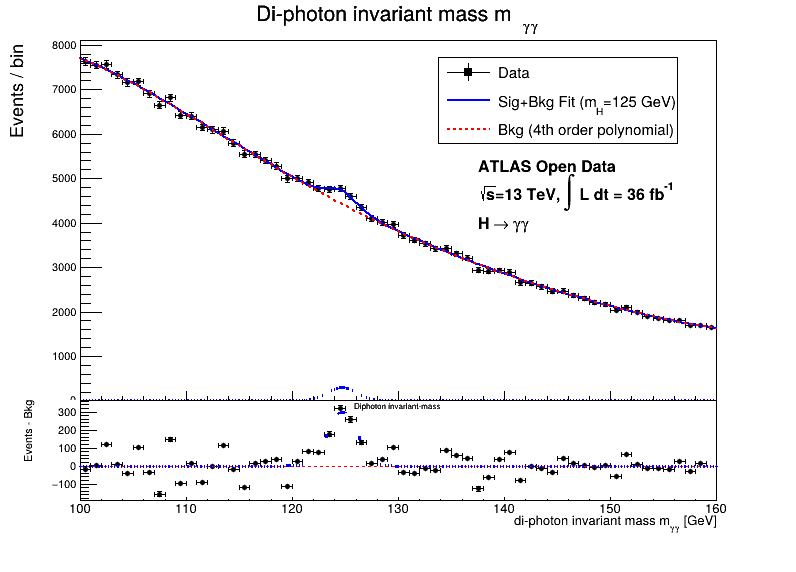

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (gauss)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


Info in <TCanvas::Print>: png file Hyy_fit_analysis.png has been created


In [15]:
# =======================
# Main Pad (Data + Fit)
# =======================
canvas = ROOT.TCanvas("canvas", "canvas", 800, 600)
    
mainPad = ROOT.TPad("mainPad", "mainPad", 0, 0.3, 1, 1.0)
mainPad.SetBottomMargin(0)
mainPad.Draw()
mainPad.cd()

# Get histogram representation of data and background
# Ensure both histograms use the same binning

nbins = hist.GetNbinsX()
xmin = hist.GetXaxis().GetXmin()
xmax = hist.GetXaxis().GetXmax()

h_data = data.createHistogram("h_data", x, ROOT.RooFit.Binning(nbins, xmin, xmax));
h_bkg  = bkg.createHistogram("h_bkg", x, ROOT.RooFit.Binning(nbins, xmin, xmax));

print(f"nbins h_data: {h_data.GetNbinsX()}")
print(f"nbins h_bkg: {h_bkg.GetNbinsX()}")

print("===================================================================")
print(f"integral h_bkg: {h_bkg.Integral()}")
print(f"nbkg expected: {nbkg}")

# Normalize background histogram to expected number of events. The h_bkg is normalized to 1, so 
# that's why we need to scale it with the nbkg estimation given in the fitted model
h_bkg.Scale(nbkg.getVal() / h_bkg.Integral())

# Create residual histogram (data - bkg)
resid = ROOT.TH1F("residual","Diphoton invariant-mass ; Invariant Mass m_{yy} [GeV] ; events",60,100,160)

for i in range(h_data.GetNbinsX()):
    data_value = h_data.GetBinContent(i)
    bkg_value = h_bkg.GetBinContent(i)
    
    # residual value
    res_value  = data_value - bkg_value
    resid.SetBinContent(i, res_value)

# --- Plot results ---
frame = x.frame()
data.plotOn(frame, ROOT.RooFit.MarkerStyle(20), ROOT.RooFit.MarkerSize(0.5))
model.plotOn(frame, ROOT.RooFit.Name("sig_bkg_curve"), ROOT.RooFit.LineWidth(2), 
             ROOT.RooFit.LineColor(ROOT.kBlue))
model.plotOn(frame, ROOT.RooFit.Components("bkg"), ROOT.RooFit.LineWidth(2), ROOT.RooFit.LineStyle(ROOT.kDashed), 
             ROOT.RooFit.LineColor(ROOT.kRed), ROOT.RooFit.Name("bkg_curve"))
model.plotOn(frame, ROOT.RooFit.Components("gauss"), ROOT.RooFit.LineStyle(ROOT.kDotted), 
             ROOT.RooFit.LineColor(ROOT.kBlue), ROOT.RooFit.Name("gaussian_curve"))

frame.SetTitle("Di-photon invariant mass m_{#gamma#gamma}")
frame.GetYaxis().SetTitle("Events / bin")
frame.GetXaxis().SetTitleSize(0.05)   # size of x-axis title
frame.GetYaxis().SetTitleSize(0.05)   # size of y-axis title
frame.GetXaxis().SetLabelSize(0.03)   # size of x-axis labels
frame.GetYaxis().SetLabelSize(0.03)   # size of y-axis labels
frame.GetXaxis().SetTitleFont(42)     # Helvetica (ROOT default)
frame.GetYaxis().SetTitleFont(42)

frame.Draw()
canvas.cd()

# Legend

sig_bkg_curve = frame.findObject("sig_bkg_curve")
bkg_curve = frame.findObject("bkg_curve")

legend = ROOT.TLegend(0.55, 0.75, 0.85, 0.90)
#legend.AddEntry(frame.findObject("h_data"), "Data", "lep")
legend.AddEntry(frame, "Data", "lep")
legend.AddEntry(sig_bkg_curve, "Sig+Bkg Fit (m_{H}=125 GeV)", "l")
legend.AddEntry(bkg_curve, "Bkg (4th order polynomial)", "l")
legend.Draw()

# Labels
latex = ROOT.TLatex()
latex.SetTextSize(0.03)
latex.DrawLatexNDC(0.60, 0.70, "ATLAS Open Data")
latex.DrawLatexNDC(0.60, 0.65, "#sqrt{s}=13 TeV, #int L dt = 36 fb^{-1}")
latex.DrawLatexNDC(0.60, 0.60, "H #rightarrow #gamma#gamma")

# =======================
# Residual Pad (Data-Bkg vs Fit-Bkg)
# =======================
residPad = ROOT.TPad("residPad", "residPad", 0, 0.05, 1, 0.3)
residPad.SetTopMargin(0)
residPad.SetBottomMargin(0.3)
residPad.Draw()
residPad.cd()

# Style
resid.SetMarkerStyle(20)
resid.SetMarkerSize(0.5)
resid.SetLineColor(ROOT.kBlack)
resid.GetYaxis().SetTitle("Events - Bkg")
resid.GetYaxis().SetTitleSize(0.08)
resid.GetYaxis().SetTitleOffset(0.5)
resid.GetYaxis().SetLabelSize(0.08)
resid.GetXaxis().SetTitle("di-photon invariant mass m_{#gamma#gamma} [GeV]")
resid.GetXaxis().SetTitleSize(0.10)
resid.GetXaxis().SetLabelSize(0.10)
resid.SetStats(0)

# Draw residuals (data - bkg)
resid.Draw("E1")

# Zero line
zeroLine = ROOT.TLine(100, 0, 160, 0)
zeroLine.SetLineColor(ROOT.kRed)
zeroLine.SetLineStyle(2)
zeroLine.Draw("same")

gaussian_curve = frame.findObject("gaussian_curve")
gaussian_curve.Draw("same")

canvas.Draw()

# If you want a copy of your plot locally, uncomment the following line
# c.SaveAs("Hyy_fit_analysis.pdf") # pdf image

In [16]:
end = time.time()
duration = end-start
print("Finished in {} min {} s".format(int(duration//60),int(duration%60))) # Python3

Finished in 11 min 32 s


**Done!**